In [56]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import os


import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("./files/Aquifer_Petrignano.csv")

### Simplifications for the sake of the tutorial ###
# Drop data before 2009 for the purpose of this tutorial
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# Drop one of the target columns, so we can focus on only one target
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

# Simplify column names
df.columns = ['Date', 'Rainfall', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry']

targets = ['Depth_to_Groundwater']
features = [feature for feature in df.columns if feature not in targets]
from datetime import datetime, date

df.index = pd.to_datetime(df.Date, format = '%d/%m/%Y', )
df = df.drop(['Date'], axis=1)
df.head()

,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
Date,,,,,
2009-01-01,0.0,-31.14,5.2,-24530.688,2.4
2009-01-02,0.0,-31.11,2.3,-28785.888,2.5
2009-01-03,0.0,-31.07,4.4,-25766.208,2.4
2009-01-04,0.0,-31.05,0.8,-27919.296,2.4
2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3


In [57]:
df.isnull().sum()

Rainfall                 0
Depth_to_Groundwater    27
Temperature              0
Drainage_Volume          1
River_Hydrometry         0
dtype: int64

In [58]:
df['Drainage_Volume'] = df['Drainage_Volume'].interpolate()
#df['River_Hydrometry'] = df['River_Hydrometry'].interpolate()
df['Depth_to_Groundwater'] = df['Depth_to_Groundwater'].interpolate()

In [59]:
uni = df['Depth_to_Groundwater']
uni

Date
2009-01-01   -31.14
2009-01-02   -31.11
2009-01-03   -31.07
2009-01-04   -31.05
2009-01-05   -31.01
              ...  
2020-06-26   -25.07
2020-06-27   -25.11
2020-06-28   -25.19
2020-06-29   -25.18
2020-06-30   -25.25
Name: Depth_to_Groundwater, Length: 4199, dtype: float64

In [60]:
# params
WINDOW_SIZE = 5


In [61]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [62]:
from tensorboard.plugins.hparams import api as hp

In [63]:
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [64]:
X1, y1 = df_to_X_y(uni, WINDOW_SIZE)
X1.shape, y1.shape

((4194, 5, 1), (4194,))

In [65]:
X_train1, y_train1 = X1[:2000], y1[:2000]
X_val1, y_val1 = X1[2000:4000], y1[2000:4000]
X_test1, y_test1 = X1[4000:], y1[4000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((2000, 5, 1), (2000,), (2000, 5, 1), (2000,), (194, 5, 1), (194,))

In [76]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32, 64]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd' ,'nadam']))

METRIC_RMSE = 'RootMeanSquaredError'

logdir = 'logs/hparam_tuning'
with tf.summary.create_file_writer(logdir).as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC_RMSE, display_name='RMSE')]
    )


num_units': 64, 'dropout': 0.1, 'optimizer': 'adam'

In [77]:
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

def train_test_model(hparams):
    model = Sequential()
    model.add(InputLayer((5, 1)))
    model.add(LSTM(hparams[HP_NUM_UNITS]))
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))
    model.compile(loss=MeanSquaredError(), optimizer=hparams[HP_OPTIMIZER], metrics=['RootMeanSquaredError'])
    model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[
        tf.keras.callbacks.TensorBoard(logdir),  # log metrics
        hp.KerasCallback(logdir, hparams),  # log hparams
    ])
    _, rmse = model.evaluate(X_test1, y_test1)
    return  rmse

In [78]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        rmse = train_test_model(hparams)
        tf.summary.scalar(METRIC_RMSE, rmse, step=10)


In [79]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
            hparams = {
                HP_NUM_UNITS: num_units,
                HP_DROPOUT: dropout_rate,
                HP_OPTIMIZER: optimizer,
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run('logs/hparam_tuning/' + run_name, hparams)
            session_num += 1


--- Starting trial: run-0
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'adam'}
Epoch 1/10
63/63 [==============================] - 4s 16ms/step - loss: 685.8830 - root_mean_squared_error: 26.1894 - val_loss: 546.6235 - val_root_mean_squared_error: 23.3800
Epoch 2/10
63/63 [==============================] - 0s 8ms/step - loss: 623.8685 - root_mean_squared_error: 24.9774 - val_loss: 477.9697 - val_root_mean_squared_error: 21.8625
Epoch 3/10
63/63 [==============================] - 0s 7ms/step - loss: 518.0897 - root_mean_squared_error: 22.7616 - val_loss: 346.0583 - val_root_mean_squared_error: 18.6026
Epoch 4/10
63/63 [==============================] - 1s 8ms/step - loss: 369.5944 - root_mean_squared_error: 19.2248 - val_loss: 221.7126 - val_root_mean_squared_error: 14.8900
Epoch 5/10
63/63 [==============================] - 1s 8ms/step - loss: 245.7844 - root_mean_squared_error: 15.6775 - val_loss: 135.3204 - val_root_mean_squared_error: 11.6327
Epoch 6/10
63/63 [====================

{'num_units': 32, 'dropout': 0.1, 'optimizer': 'nadam'} 0.0933
{'num_units': 64, 'dropout': 0.1, 'optimizer': 'nadam'} 0.08706
{'num_units': 64, 'dropout': 0.2, 'optimizer': 'adam'} 0.0856

In [80]:
%tensorboard --logdir logs/hparam_tuning

Launching TensorBoard...

In [81]:
import winsound
winsound.Beep(2500,1000)

In [11]:
from keras.models import load_model
model1 = load_model('model1/')

In [12]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

63/63 [==============================] - 1s 2ms/step


,Train Predictions,Actuals
0,-31.163076,-31.00
1,-31.137287,-30.96
2,-31.105312,-30.94
3,-31.079294,-30.93
4,-31.054319,-30.87
...,...,...
1995,-19.884098,-19.89
1996,-19.921623,-19.88
1997,-19.934490,-19.90
1998,-19.932564,-19.94


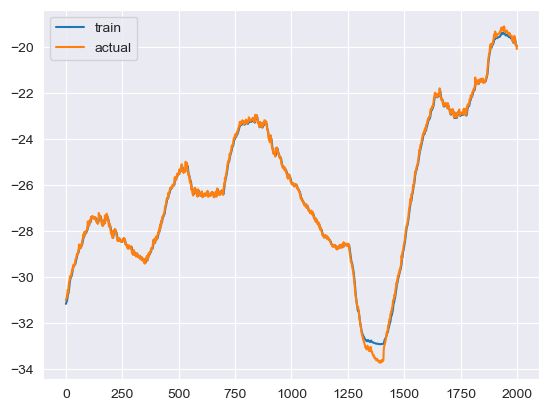

In [13]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'], label="train")
plt.plot(train_results['Actuals'], label="actual")
plt.legend(loc="upper left")

In [14]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

63/63 [==============================] - 0s 2ms/step


,Val Predictions,Actuals
0,-20.007832,-20.05
1,-20.040623,-20.05
2,-20.074049,-20.04
3,-20.067081,-20.10
4,-20.082506,-20.17
...,...,...
1995,-26.058033,-26.18
1996,-26.084623,-26.15
1997,-26.131878,-26.16
1998,-26.161484,-26.06


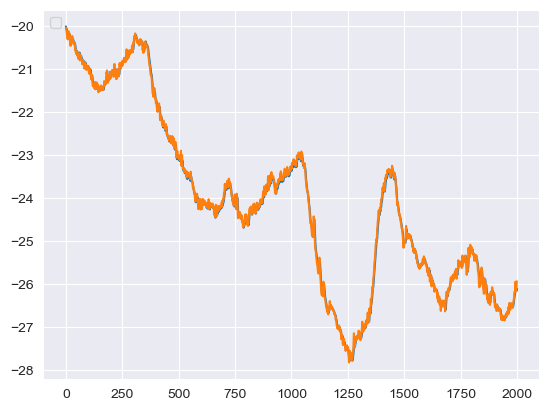

In [15]:
plt.plot(val_results['Val Predictions'])
plt.plot(val_results['Actuals'])
plt.legend(loc="upper left")

In [16]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

7/7 [==============================] - 0s 2ms/step


,Test Predictions,Actuals
0,-26.046928,-25.92
1,-25.978764,-25.84
2,-25.900290,-25.86
3,-25.878029,-25.97
4,-25.902332,-26.01
...,...,...
189,-24.991781,-25.07
190,-25.041794,-25.11
191,-25.090483,-25.19
192,-25.137859,-25.18


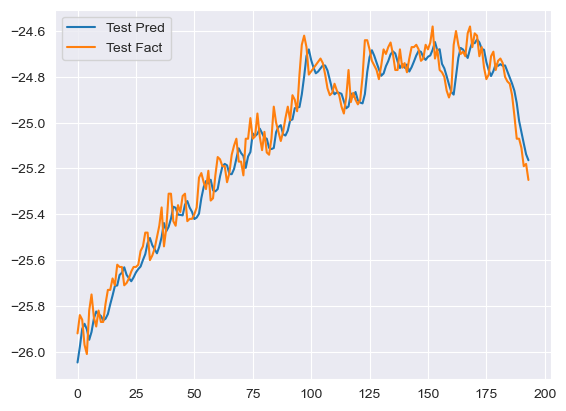

In [17]:
plt.plot(test_results['Test Predictions'], label="Test Pred")
plt.plot(test_results['Actuals'], label="Test Fact")
plt.legend()

In [18]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    return df, mse(y, predictions)

7/7 [==============================] - 0s 2ms/step


(     Predictions  Actuals
 0     -26.046928   -25.92
 1     -25.978764   -25.84
 2     -25.900290   -25.86
 3     -25.878029   -25.97
 4     -25.902332   -26.01
 ..           ...      ...
 189   -24.991781   -25.07
 190   -25.041794   -25.11
 191   -25.090483   -25.19
 192   -25.137859   -25.18
 193   -25.163872   -25.25
 
 [194 rows x 2 columns],
 0.005859440403312548)

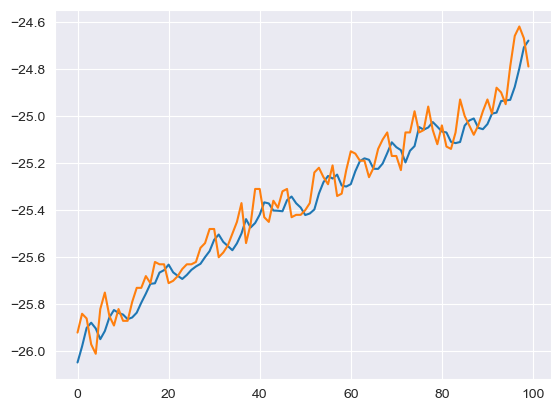

In [19]:
plot_predictions1(model1, X_test1, y_test1)